### Benchmark
compare the loop and vectorized implementation.

  * Loop through each node: [model/queue_class_ce170.py](model/queue_class_ce170.py)
  * Vectorized: [model/spatial_queue_array.py](model/spatial_queue_array.py)

In [1]:
import sys
import time 
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
random.seed(0)
np.random.seed(0)

### spatial queue model
sys.path.insert(0, '..')
import model.queue_class_ce170 as sq_loop
import model.spatial_queue_array as sq_vect

In [23]:
### Read network and demand
case='fairfax'
nodes_df = pd.read_csv('traffic_inputs/{}_nodes.csv'.format(case))
links_df = pd.read_csv('traffic_inputs/{}_links.csv'.format(case))
od_df = pd.read_csv('traffic_inputs/{}_ods_day.csv'.format(case))

### these are done for the vectorized implementation
if case == 'berkeley':
    osmid2nid_dict = {getattr(n, 'node_osmid'): getattr(n, 'node_id') for n in nodes_df.itertuples()}
    od_df['origin_nid'] = od_df['origin_osmid'].map(osmid2nid_dict)
    od_df['destin_nid'] = od_df['destin_osmid'].map(osmid2nid_dict)
if case == 'fairfax':
    background_od = pd.read_csv('traffic_inputs/{}_ods_background.csv'.format(case))
    od_df = pd.concat([od_df, background_od]).sample(frac=1)
    od_df['origin_nid'] = od_df['origin_node_id']
    od_df['destin_nid'] = od_df['destin_node_id']
    nodes_df['node_id'] = nodes_df['nid']
    nodes_df['node_osmid'] = None
    links_df['link_id'] = links_df['eid']
    links_df['start_node_id'] = links_df['nid_s']
    links_df['end_node_id'] = links_df['nid_e']
print('# nodes {}, # links {}, # ods {}'.format(nodes_df.shape[0], links_df.shape[0], od_df.shape[0]))

# nodes 224224, # links 549010, # ods 116203


### This is the vectorized simulation.

In [21]:
# count the number of evacuees that have successfully reach their destination
def arrival_counts_vect(t, simulation, save_path):
    arrival_cnts = np.sum(simulation.agents.agents['agent_status']==-1)
    print('At {} seconds, {} evacuees successfully reached the destination'.format(t, arrival_cnts))
    if arrival_cnts == simulation.agents.agents.shape[0]:
        print("all agents arrive at destinations at time {} seconds.".format(t))
        return False
    with open(save_path, 'a') as t_stats_outfile:
        t_stats_outfile.write("{},{}".format(t, arrival_cnts) + "\n")
    return True

# write a csv file that contains the numbers of queuing and running vehicles on each link
def write_link_outputs_vect(simulation, save_path):
    link_output = simulation.network.links.loc[
        simulation.network.links['link_type'].isin(['real', 'virtual']), 
        ['link_id', 'queue', 'run', 'undeparted', 'length', 'geometry']].copy()
    link_output = link_output[
        (link_output['queue']>0) | (link_output['run']>0)
        | (link_output['undeparted']>0)
    ]
    link_output.to_csv(save_path, index=False)


### initialize simulation
simulation_vect = sq_vect.Simulation()
simulation_vect.initialize_simulation(nodes_df, links_df, od_df)

### specify some parameters
scenario_name = '{}_vect'.format(case)
t_end = 7201
arrival_output_path = 'traffic_outputs/{}/t_stats/arrivals_{}.csv'.format(case, scenario_name)

### run simulation and output results
with open(arrival_output_path, 'w') as t_stats_outfile:
    t_stats_outfile.write("t,arrival_count"+"\n")

# iterate through each time step
t_start_vect = time.time()
for t in range(t_end):
        
    # run the spatial-queue simulation for one step
    simulation_vect.run_one_step(t, reroute_frequency=None)

    # output time-step results every 100 seconds
    if t%100 == 0:
        if not arrival_counts_vect(t, simulation_vect, arrival_output_path):
            break
        link_output_path = 'traffic_outputs/{}/link_stats/l{}_at_{}.csv'.format(case, scenario_name, t)
        #node_output_path = 'traffic_outputs/berkeley/node_stats/n{}_at_{}.csv'.format(scenario_name, t)
        write_link_outputs_vect(simulation_vect, link_output_path)
        #write_node_outputs(simulation_vect, node_output_path)

print ("simulation completed")
t_end_vect = time.time()
print('Simulation took {}s'.format(t_end_vect - t_start_vect))
    

Agent IDs not specified; use sequential number.
agents departure times not specified; assume leave immediately.
At 0 seconds, 0 evacuees successfully reached the destination
At 100 seconds, 80 evacuees successfully reached the destination
At 200 seconds, 163 evacuees successfully reached the destination
At 300 seconds, 244 evacuees successfully reached the destination
At 400 seconds, 336 evacuees successfully reached the destination
At 500 seconds, 430 evacuees successfully reached the destination
At 600 seconds, 514 evacuees successfully reached the destination
At 700 seconds, 576 evacuees successfully reached the destination
At 800 seconds, 645 evacuees successfully reached the destination


KeyboardInterrupt: 

### This is the unvectorized simulation.

In [6]:
# remove vehicles from the simulation if no path can be found for it
def remove_no_path_agents(simulation):
    cannot_find_path = []
    for vehicle_id, vehicle in simulation.all_agents.items():
        routing_status = vehicle.get_path( g=simulation.g )
        if routing_status == 'no_path_found':
            cannot_find_path.append(vehicle_id)

    for vehicle_id in cannot_find_path:
        del simulation.all_agents[vehicle_id]
      
    print('# o-d pairs whose paths cannot be found: {}'.format(len(cannot_find_path)))
    print('# o-d pairs/trips {}'.format(len(simulation.all_agents)))
    return simulation

# initialize the spatial-queue model
def init_sq_simulation(nodes_df, links_df, od_df):

    simulation = sq_loop.Simulation()
    simulation.create_network(nodes_df, links_df)
    simulation.create_demand(od_df)

    simulation = remove_no_path_agents(simulation)
    return simulation

# run the spatial-queue simulation for one time step
def single_step_sq_sim(simulation,t,reroute_frequency):
    ### load agents
    for agent_id, agent in simulation.all_agents.items(): 
        agent.load_trips(t)
        ### reroute
        if (t>0) and (t%reroute_frequency == 0):
            routing_status = agent.get_path( g=simulation.g )
    ### run link model
    for link_id, link in simulation.all_links.items():
        link.run_link_model(t)
    ### run node model
    node_ids_to_run = set([link.end_nid for link in simulation.all_links.values() if len(link.queue_veh)>0])
    for node_id in node_ids_to_run:
        node = simulation.all_nodes[node_id] 
        node.run_node_model(t)
    return simulation

# count the number of evacuees that have successfully reach their destination
def arrival_counts(t,simulation,save_path):
    arrival_cnts = np.sum([1 for a in simulation.all_agents.values() if a.status=='arr'])
    print('At {} seconds, {} evacuees successfully reached the destination'.format(t, arrival_cnts))
    if arrival_cnts == len(simulation.all_agents):
        print("all agents arrive at destinations at time {} seconds.".format(t))
        return False
    with open(save_path, 'a') as t_stats_outfile:
        t_stats_outfile.write("{},{}".format(t, arrival_cnts) + "\n")
    return True

# write a csv file that contains the numbers of queuing and running vehicles on each link
def write_link_outputs(simulation,save_path):
    link_output = pd.DataFrame(
        [(link.lid, len(link.queue_veh), len(link.run_veh), 
          np.round((len(link.queue_veh)+len(link.run_veh))/(link.length * link.lanes+0.00001)*100, 2), 
          link.geometry) for link in simulation.all_links.values() 
         #if link.ltype[0:2]!='vl'
        ], 
        columns=['link_id', 'queue_vehicle_count', 'run_vehicle_count', 'vehicle_per_100m', 'geometry'])
    link_output = link_output[(link_output['queue_vehicle_count']>0) | (link_output['run_vehicle_count']>0)].reset_index(drop=True)
    link_output.to_csv(save_path, index=False)

# write a csv file that contains the numbers of vehicles that have not departed and waiting at each node
def write_node_outputs(simulation,save_path):
    node_predepart = pd.DataFrame([(agent.cle, 1) for agent in simulation.all_agents.values() if (agent.status in [None, 'loaded'])], columns=['node_id', 'predepart_cnt']).groupby('node_id').agg({'predepart_cnt': np.sum}).reset_index()
    if node_predepart.shape[0]>0:
        node_predepart = node_predepart.merge(nodes_df[['node_id', 'lat', 'lon']], how='left', on='node_id')
        node_predepart.to_csv(save_path, index=False)

def spatial_queue_simulation(t_end,simulation,scenario_name,reroute_frequency):
    # paths 
    arrival_output_path = 'traffic_outputs/{}/t_stats/arrivals_{}.csv'.format(case, scenario_name)
    with open(arrival_output_path, 'w') as t_stats_outfile:
        t_stats_outfile.write("t,arrival_count"+"\n")

    t_start_loop = time.time()
    # iterate through each time step
    for t in range(t_end):

        # run the spatial-queue simulation for one step
        simulation = single_step_sq_sim(simulation,t,reroute_frequency)

        # output time-step results every 100 seconds
        if t%100 == 0:
            if not arrival_counts(t,simulation,arrival_output_path):
                break
            link_output_path = 'traffic_outputs/{}/link_stats/l{}_at_{}.csv'.format(case, scenario_name, t)
            node_output_path = 'traffic_outputs/{}/node_stats/n{}_at_{}.csv'.format(case, scenario_name, t)
            write_link_outputs(simulation,link_output_path)
            write_node_outputs(simulation,node_output_path)

    print ("simulation completed")
    t_end_loop = time.time()
    print("Simulation took {}s".format(t_end_loop-t_start_loop))
    return simulation

In [9]:
simulation = init_sq_simulation(nodes_df,links_df,od_df)
spatial_queue_simulation(4200, simulation, '{}_loop'.format(case), 36000)

# o-d pairs whose paths cannot be found: 0
# o-d pairs/trips 3947
At 0 seconds, 0.0 evacuees successfully reached the destination
At 100 seconds, 78 evacuees successfully reached the destination
At 200 seconds, 261 evacuees successfully reached the destination
At 300 seconds, 470 evacuees successfully reached the destination
At 400 seconds, 643 evacuees successfully reached the destination
At 500 seconds, 826 evacuees successfully reached the destination
At 600 seconds, 1006 evacuees successfully reached the destination
At 700 seconds, 1159 evacuees successfully reached the destination
At 800 seconds, 1305 evacuees successfully reached the destination
At 900 seconds, 1460 evacuees successfully reached the destination
At 1000 seconds, 1620 evacuees successfully reached the destination
At 1100 seconds, 1757 evacuees successfully reached the destination
At 1200 seconds, 1905 evacuees successfully reached the destination
At 1300 seconds, 2031 evacuees successfully reached the destination
A

### Plot results

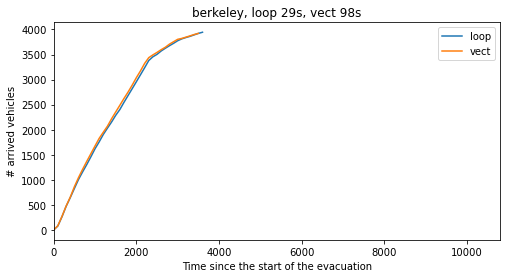

In [19]:
### plot the arrival curve
fig, ax = plt.subplots(figsize=(8, 4))

### base scenario arrival
t_stats_loop_df = pd.read_csv('traffic_outputs/{}/t_stats/arrivals_{}_loop.csv'.format(case, case))
ax.plot(t_stats_loop_df['t'], t_stats_loop_df['arrival_count'], label='loop')

t_stats_vect_df = pd.read_csv('traffic_outputs/{}/t_stats/arrivals_{}_vect.csv'.format(case, case))
ax.plot(t_stats_vect_df['t'], t_stats_vect_df['arrival_count'], label='vect')

ax.set_xlabel('Time since the start of the evacuation')
ax.set_ylabel('# arrived vehicles')
ax.set_xlim([0, 10800])
plt.legend()
plt.title('{}, loop {}s, vect {}s'.format(case, 29, 98))
plt.show()